# Preprocesamiento de Datos
Una vez disponemos de nuestra partición de entrenamiento, vamos a comenzar con el preprocesamiento de los datos.

Dado que los datos ya están depurados al haberse calculado previamente a partir de datos en bruto, centraremos el preprocesamiento en las tareas de estandarización e imputación de valores ausentes.

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from scipy.stats import kstest
from scipy.stats import ttest_ind, mannwhitneyu
from scipy import stats

In [2]:
# Cargamos nuestro dataset de entrenamiento
data_train = pd.read_csv('../particiones/train.csv', sep=';', na_values='', decimal=',')

# Cargamos nuestro dataset de test
data_test = pd.read_csv('../particiones/test.csv', sep=';', na_values='', decimal=',')

## 1.- Separación entre datos y etiquetas

Procedemos a separar los atributos y la variable target:

In [3]:
def separa_X_y(data):
    X = data.iloc[:, :11].to_numpy(na_value=np.nan)
    y = data['crisisJST'].to_numpy()
    columna_anios = data['year'].to_numpy()

    nombres_atributos_original = list(data.iloc[:, :11].columns)
    print(nombres_atributos_original)
    
    return X, y, nombres_atributos_original, columna_anios

## 2.- Estandarización de Datos

In [4]:
def estandarizar(X_train, X_test):
    standardizer = StandardScaler()
    X_train_std = standardizer.fit_transform(X_train)
    X_test_std = standardizer.transform(X_test)

    # Comparamos los valores de entrenamiento antes y después de estandarizar
    print(X_train[0])
    print('---------')
    print(X_train_std[0])
    
    return X_train_std, X_test_std, standardizer

## 3.- Imputación de Valores Ausentes
Vamos a plantear tres posibles estrategias para la imputación de valores ausentes:
* Eliminación de registros.
* Imputación por el valor medio.
* Uso de algoritmo K-Nearest Neighbors.

Para cada caso crearemos una nueva partición a partir de nuestro dataset de entrenamiento para su uso en fases posteriores.

Revisaremos también posibles atributos para los cuales el volumen global de valores ausentes es muy elevado, ya que en caso de tratarse de un volumen excesivo no tendría sentido mantener esas características porque o bien acabarían provocando tener que eliminar todos los registros porque todas las instancias tendrían algún valor nulo entre sus características, o bien los valores de imputación serán básicamente siempre los mismos por lo que el nivel de varianza y por tanto la utilidad predictiva será prácticamente nula.

Estableceremos un umbral para eliminar todos aquellos atributos que tengan un porcentaje de valores ausentes superior al 30%.

### 3.1.- Eliminación de atributos por missing value ratio

In [5]:
def eliminacion_missing_value_ratio(X_train, X_test, atributos_origen):

    # Eliminamos los atributos con volumen de valores ausentes > 30%    
    # Presentamos las dimensiones de datos originales
    print(f'Atributos Originales: {X_train.shape[0]}')
    
    num_ausentes = np.sum(np.isnan(X_train),axis=0)
    porcentaje = np.round(num_ausentes / X_train.shape[0] * 100, 2)
    mask = porcentaje>30
    porcentaje = porcentaje[porcentaje>30]

    atributos_borrar = np.where(mask==True)[0].tolist()
    
    print(f'Número de Atributos eliminados: {len(porcentaje)}')
    nuevos_atributos = atributos_origen.copy()
    if not atributos_borrar == []:
        print(f'Porcentaje Máximo: {np.max(porcentaje)}')
        print(f'Porcentaje Mínimo: {np.min(porcentaje)}')
    
        X_train = np.delete(X_train, atributos_borrar, axis=1)
        X_test = np.delete(X_test, atributos_borrar, axis=1)
        nuevos_atributos = [i for j, i in enumerate(atributos_origen) if j not in atributos_borrar]
   
    return X_train, X_test, nuevos_atributos

### 3.2.- Estrategias de Imputación de Valores Ausentes

#### 3.2.1.- Estrategia 1: Eliminación de registros con valores ausentes

In [6]:
def elimina_ausentes(X, y, X_test, y_test, columna_anios):
    
    # Presentamos los volúmenes de datos
    print(X.shape)
    print(y.shape)
    _, ocurrencias = np.unique(y, return_counts=True)
    print(f'Distribución de Muestras:[No Crisis Pre-Crisis] - {ocurrencias}')
    
    # Eliminación de registros: borraremos todos aquellos registros para los que alguno de los valores de los atributos no esté presente
    X_aux = X.copy()
    mask = np.isnan(X_aux).any(axis=1)
    registros_borrar = np.where(mask==True)

    X_aux = np.delete(X_aux, registros_borrar, axis=0)

    # Tenemos que borrar también las etiquetas
    y_aux = y.copy()
    y_aux = np.delete(y_aux, registros_borrar, axis=0)
    columna_aux = columna_anios.copy()
    columna_aux = np.delete(columna_aux, registros_borrar, axis=0)

    # Tenemos que borrar también las muestras de test
    
    X_test_aux = X_test.copy()
    mask = np.isnan(X_test_aux).any(axis=1)
    registros_borrar = np.where(mask==True)
    X_test_aux = np.delete(X_test_aux, registros_borrar, axis=0)

    y_test_aux = y_test.copy()
    y_test_aux = np.delete(y_test_aux, registros_borrar, axis=0)

    # Presentamos los nuevos volúmenes de datos tras eliminar los registros
    print(X_aux.shape)
    print(y_aux.shape)
    _, ocurrencias = np.unique(y_aux, return_counts=True)
    print(f'Distribución de Muestras de Entrenamiento:[No Crisis Pre-Crisis] - {ocurrencias}')

    print(X_test_aux.shape)
    print(y_test_aux.shape)
    _, ocurrencias = np.unique(y_test_aux, return_counts=True)
    print(f'Distribución de Muestras de Test:[No Crisis Pre-Crisis] - {ocurrencias}')

    return X_aux, y_aux, X_test_aux, y_test_aux, columna_aux

#### 3.2.2.- Estrategia 2: Imputación de valores ausentes con valor medio

In [7]:
def imputa_ausentes_media(X_train, X_test):

    # Imputación de valores ausentes por valor medio
    X_train_media = X_train.copy()
    X_test_media = X_test.copy()

    imp = SimpleImputer(strategy='mean') # Utilizamos la estrategia de la media
    X_train_media = imp.fit_transform(X_train_media)
    X_test_media = imp.transform(X_test_media)

    print(X_train_media.shape)
    print(X_test_media.shape)

    return X_train_media, X_test_media, imp

#### 3.2.3.- Estrategia 3: Imputación de valores ausentes mediante algoritmo KNN

In [8]:
def imputa_ausentes_knn(X_train, X_test):

    # Imputación de valores ausentes mediante KNN
    X_train_knn = X_train.copy()
    X_test_knn = X_test.copy()

    imp = KNNImputer()
    X_train_knn = imp.fit_transform(X_train_knn)
    X_test_knn = imp.transform(X_test_knn)

    print(X_train_knn.shape)
    print(X_test_knn.shape)

    return X_train_knn, X_test_knn, imp

In [9]:
# def elimina_outliers(X_in, y_in):
#     pos_outliers = []

#     paises_unicos = np.unique(X_in[:,12])
#     print(paises_unicos)
    
#     for j in range(len(paises_unicos)):
#         aux = X_in[X_in[:, 12] == paises_unicos[j]]
#         # for i in range(0, X_in.shape[1]):
#         for i in range(0, aux.shape[1]-3):
#             #print(i)
#             # atributo = X_in[:, i] # Recorremos todos los atributos
#             atributo = aux[:, i] # Recorremos todos los atributos
        
#             # Seleccionamos los umbrales a partir de los cuales vamos a considerar outliers
#             Q1 = stats.scoreatpercentile(atributo, 25)
#             Q3 = stats.scoreatpercentile(atributo, 75)
#             RIC = Q3 - Q1
#             li = Q1 - 3.*RIC
#             ls = Q3 + 3.*RIC
    
#             print(Q1)
#             print(Q3)
    
#             # Buscamos la posición de los outliers
#             pos_i = np.where(atributo<li)[0]
#             pos_s = np.where(atributo>ls)[0]
#             pos_out = list(np.concatenate((pos_i, pos_s)))      
#             pos_outliers += pos_out
#             # print(nombres_atributos_intermedio[i])
#             # print(pos_outliers)
#             # print(X_in[pos_outliers[0]])
#         print(X_in.shape)
#         print(len(pos_outliers))

    

    
#     # X_out = X_in.copy()
#     # X_out = np.delete(X_out, pos_outliers, axis=0)
#     # y_out = y_in.copy()
#     # y_out = np.delete(y_out, pos_outliers, axis=0)
#     # print(f'Instancias Iniciales: {X_in.shape[0]}\nInstancias Finales: {X_out.shape[0]}')
#     # return (X_out, y_out)

## 4.- Evaluación de atributos discriminativos

In [41]:
def evalua_atributos_discriminativos(X_train, y_train, X_test, atributos_origen, nombre_grafica):
    alpha=0.01
    h_norm=np.zeros(X_train.shape[1])

    nocrisis_data= X_train[y_train==0]
    crisis_data= X_train[y_train==1]

    h=np.zeros(X_train.shape[1])
    h_disc=np.zeros(X_train.shape[1])
    
    for i in range(0,X_train.shape[1]):
        _, p_value=kstest(X_train[:,i],'norm')
        if p_value<=alpha:
            h_norm[i]=0
        else:
            h_norm[i]=1

        if h_norm[i]==0:
            _,p_value=mannwhitneyu(crisis_data[:,i], nocrisis_data[:,i])
        else:
            _,p_value=ttest_ind(crisis_data[:,i], nocrisis_data[:,i])
    
        if p_value<=alpha:
            h_disc[i]=1
        else:
            h_disc[i]=0

    id_no_disc = np.where(h_disc==0)
    
    print('0 no normal, 1 sí normal', h_norm)
    print('0 no discrimina 1 sí discrimina', h_disc)
    print(f'Número de atributos discriminativos: {h_disc.sum()}')

    X_train_disc = X_train.copy()
    X_test_disc = X_test.copy()
    
    X_train_disc = np.delete(X_train_disc, id_no_disc[0], axis=1)
    X_test_disc = np.delete(X_test_disc, id_no_disc[0], axis=1)
    atributos_discriminativos = [atributos_origen[i] for i,_ in enumerate(atributos_origen) if h_disc[i]==1]

    # Pinto las gráficas de box-plot para los atributos discriminativos
    no_crisis= X_train_disc[y_train==0]
    pre_crisis= X_train_disc[y_train==1]
  
    bpl = plt.boxplot(no_crisis, positions=np.array(range(np.shape(no_crisis)[1]))*2.0-0.4, sym='', widths=0.5,
                      boxprops=dict(color='#dd3c12'),
                      capprops=dict(color='#dd3c12'),
                      whiskerprops=dict(color='#dd3c12'),
                      medianprops=dict(color='#dd3c12'))
    bpl = plt.boxplot(pre_crisis, positions=np.array(range(np.shape(no_crisis)[1]))*2.0+0.4, sym='', widths=0.5,
                      boxprops=dict(color='#f4c4b8'),
                      capprops=dict(color='#f4c4b8'),
                      whiskerprops=dict(color='#f4c4b8'),
                      medianprops=dict(color='#f4c4b8'))
    plt.plot([], c='#dd3c12', label='No Crisis')
    plt.plot([], c='#f4c4b8', label='Pre-Crisis')
    plt.legend()
    plt.title('Atributos Discriminativos')

        # Guardo las gráficas para la presentación en app
    if not os.path.exists('../app/graficas'):
        os.mkdir('../app/graficas')

    plt.savefig('../app/graficas/' + nombre_grafica + '.png')
    
    plt.show()

    return X_train_disc, X_test_disc, atributos_discriminativos

## 5.- Análisis de Correlación de Atributos

In [11]:
def atributos_correlados(X, nombre_grafica):

    # Guardo las gráficas para la presentación en app
    if not os.path.exists('../app/graficas'):
        os.mkdir('../app/graficas')
    
    R = np.corrcoef(X.transpose())
    plt.imshow(R, cmap='OrRd')
    plt.title('Coeficientes de Correlación')
    plt.savefig('../app/graficas/' + nombre_grafica + '.png')
    plt.show()
    
    corr_th = 0.9
    idx = abs(R) > corr_th
    mts = np.triu(idx,1)
    rows, cols = np.where(mts==True)
    
    id_corr = np.unique(cols)
    if not id_corr.size > 0:
        print('No hay atributos con alta correlación')
    else:
        print(id_corr)

## 5.- Creación de Particiones
A través de las funciones anteriores procederemos a crear las distintas particiones en base a las distintas estrategias de imputación a partir de los dos casos iniciales (con eventos historicos excepcionales y sin eventos históricos excepcionales).

In [12]:
# Separamos datos X e y
X_train, y_train, nombre_atributos_original, columna_anios = separa_X_y(data_train)
X_test, y_test, _, _ = separa_X_y(data_test)

['cpi_dif_por2', 'money_pib_dif_abs2', 'rconsbarro_dif_por2', 'pdebt_pib_dif_abs2', 'inv_pib_dif_abs2', 'ca_pib_dif_abs2', 'tloans_pib_dif_abs2', 'tdbtserv_pib_dif_abs2', 'global_loan2', 'global_drate', 'drate']
['cpi_dif_por2', 'money_pib_dif_abs2', 'rconsbarro_dif_por2', 'pdebt_pib_dif_abs2', 'inv_pib_dif_abs2', 'ca_pib_dif_abs2', 'tloans_pib_dif_abs2', 'tdbtserv_pib_dif_abs2', 'global_loan2', 'global_drate', 'drate']


In [13]:
# Estandarizamos
X_train_std, X_test_std, estandarizador = estandarizar(X_train, X_test)

[ 0.04761905  0.08925547  0.15295406  0.137642    0.0451141  -0.07703094
         nan         nan -0.02692469  1.29883536         nan]
---------
[-0.14776343  1.09491589  1.19869266  1.5146299   1.64028195 -2.60668439
         nan         nan -2.4130395   0.25241815         nan]


In [14]:
# Eliminacion de atributos por Missing Value Ratio
X_train_std, X_test_std, nuevos_atributos = eliminacion_missing_value_ratio(X_train_std, X_test_std, nombre_atributos_original)

Atributos Originales: 984
Número de Atributos eliminados: 0


#### 5.1- Valores Ausentes - Eliminación

In [15]:
X_train_std_deleted, y_train_deleted, X_test_std_deleted, y_test_deleted, columna_anios_deleted = elimina_ausentes(X_train_std, y_train, X_test_std, y_test, columna_anios)

(984, 11)
(984,)
Distribución de Muestras:[No Crisis Pre-Crisis] - [960  24]
(873, 11)
(873,)
Distribución de Muestras de Entrenamiento:[No Crisis Pre-Crisis] - [849  24]
(238, 11)
(238,)
Distribución de Muestras de Test:[No Crisis Pre-Crisis] - [212  26]


#### 5.2- Valores Ausentes - Imputación de Media

In [16]:
X_train_std_media, X_test_std_media, imp_media = imputa_ausentes_media(X_train_std, X_test_std)
y_train_media = y_train.copy()
y_test_media = y_test.copy()

(984, 11)
(241, 11)


#### 5.3- Valores Ausentes - Imputación KNN

In [17]:
X_train_std_knn, X_test_std_knn, imp_knn = imputa_ausentes_knn(X_train_std, X_test_std)
y_train_knn = y_train.copy()
y_test_knn = y_test.copy()

(984, 11)
(241, 11)


In [18]:
# elimina_outliers(X_train_std_knn, y_train_knn)

0 no normal, 1 sí normal [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 no discrimina 1 sí discrimina [1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
Número de atributos discriminativos: 7.0


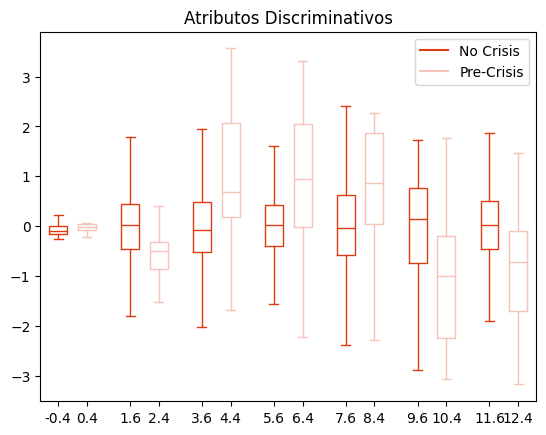

In [42]:
X_train_std_disc_deleted, X_test_std_disc_deleted, atributos_discriminativos_deleted = evalua_atributos_discriminativos(X_train_std_deleted, y_train_deleted, X_test_std_deleted, nuevos_atributos, 'disc_deleted')

0 no normal, 1 sí normal [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 no discrimina 1 sí discrimina [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
Número de atributos discriminativos: 6.0


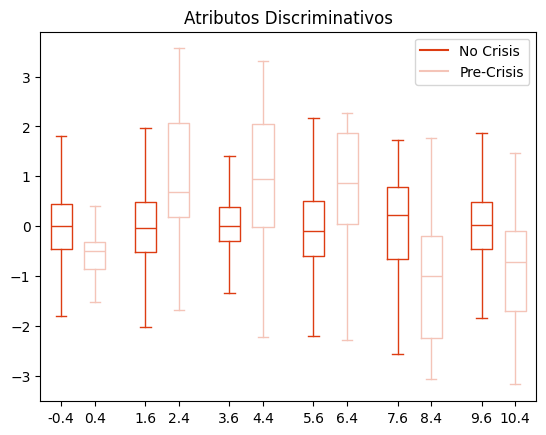

In [43]:
X_train_std_disc_media, X_test_std_disc_media, atributos_discriminativos_media = evalua_atributos_discriminativos(X_train_std_media, y_train_media, X_test_std_media, nuevos_atributos, 'disc_media')

0 no normal, 1 sí normal [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 no discrimina 1 sí discrimina [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
Número de atributos discriminativos: 6.0


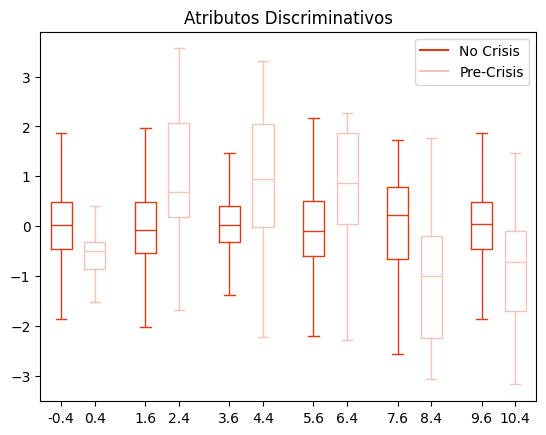

In [44]:
X_train_std_disc_knn, X_test_std_disc_knn, atributos_discriminativos_knn = evalua_atributos_discriminativos(X_train_std_knn, y_train_knn, X_test_std_knn, nuevos_atributos, 'disc_knn')

In [22]:
# print(X_train_std_knn.shape)
# print(X_train_std_disc_knn.shape)
# print(X_test_std_knn.shape)
# print(X_test_std_disc_knn.shape)

## 6.- Análisis de Correlación de Atributos
Vamos a revisar si existe correlación elevada entre atributos para las distintas particiones.

### 6.1.- Particiones sin eventos históricos excepcionales

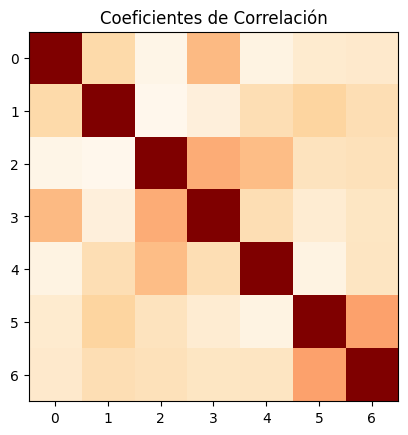

No hay atributos con alta correlación


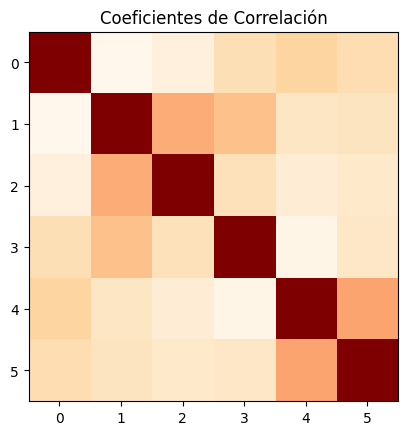

No hay atributos con alta correlación


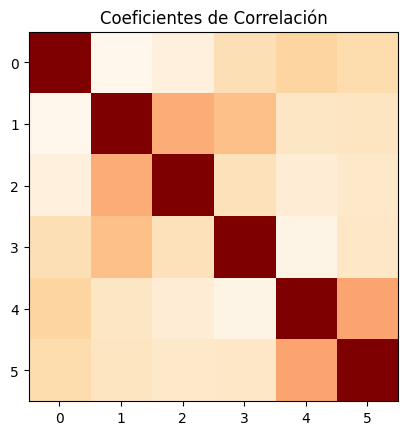

No hay atributos con alta correlación


In [23]:
atributos_correlados(X_train_std_disc_deleted, 'corr_deleted')
atributos_correlados(X_train_std_disc_media, 'corr_media')
atributos_correlados(X_train_std_disc_knn, 'corr_knn')

## 7.- Guardar particiones y Preprocesadores
Vamos a guardar las distintas particiones obtenidas, así como los imputadores, estandarizadores, etc.

In [24]:
# Guardo las particiones, nombres de atributos, imputers, scalers, etc.

if not os.path.exists('../preprocesadores'):
    os.mkdir('../preprocesadores')
    
if not os.path.exists('../particiones/preprocesadas'):
    os.mkdir('../particiones/preprocesadas')


    # Atributos
with open('../preprocesadores/nombre_atributos_original.pkl', 'wb') as f:
    pickle.dump(nombre_atributos_original, f)

with open('../preprocesadores/nuevos_atributos.pkl', 'wb') as f:
    pickle.dump(nuevos_atributos, f)



with open('../preprocesadores/atributos_discriminativos_deleted.pkl', 'wb') as f:
    pickle.dump(atributos_discriminativos_deleted, f)

with open('../preprocesadores/atributos_discriminativos_media.pkl', 'wb') as f:
    pickle.dump(atributos_discriminativos_media, f)

with open('../preprocesadores/atributos_discriminativos_knn.pkl', 'wb') as f:
    pickle.dump(atributos_discriminativos_knn, f)




    # Estandarizador e imputers
with open('../preprocesadores/estandarizador.pkl', 'wb') as f:
    pickle.dump(estandarizador, f)

with open('../preprocesadores/imp_media.pkl', 'wb') as f:
    pickle.dump(imp_media, f)

with open('../preprocesadores/imp_knn.pkl', 'wb') as f:
    pickle.dump(imp_knn, f)


    # Columna auxiliar de años para creación de folds para cross-validation
with open('../preprocesadores/columna_anios.pkl', 'wb') as f:
    pickle.dump(columna_anios, f)

with open('../preprocesadores/columna_anios_deleted.pkl', 'wb') as f:
    pickle.dump(columna_anios_deleted, f)


    # Particiones

with open('../particiones/preprocesadas/X_train_std_deleted.pkl', 'wb') as f:
    pickle.dump(X_train_std_deleted, f)

with open('../particiones/preprocesadas/y_train_deleted.pkl', 'wb') as f:
    pickle.dump(y_train_deleted, f)

with open('../particiones/preprocesadas/X_test_std_deleted.pkl', 'wb') as f:
    pickle.dump(X_test_std_deleted, f)

with open('../particiones/preprocesadas/y_test_deleted.pkl', 'wb') as f:
    pickle.dump(y_test_deleted, f)



with open('../particiones/preprocesadas/X_train_std_media.pkl', 'wb') as f:
    pickle.dump(X_train_std_media, f)

with open('../particiones/preprocesadas/y_train_media.pkl', 'wb') as f:
    pickle.dump(y_train_media, f)

with open('../particiones/preprocesadas/X_test_std_media.pkl', 'wb') as f:
    pickle.dump(X_test_std_media, f)

with open('../particiones/preprocesadas/y_test_media.pkl', 'wb') as f:
    pickle.dump(y_test_media, f)



with open('../particiones/preprocesadas/X_train_std_knn.pkl', 'wb') as f:
    pickle.dump(X_train_std_knn, f)

with open('../particiones/preprocesadas/y_train_knn.pkl', 'wb') as f:
    pickle.dump(y_train_knn, f)

with open('../particiones/preprocesadas/X_test_std_knn.pkl', 'wb') as f:
    pickle.dump(X_test_std_knn, f)

with open('../particiones/preprocesadas/y_test_knn.pkl', 'wb') as f:
    pickle.dump(y_test_knn, f)





with open('../particiones/preprocesadas/X_train_std_disc_deleted.pkl', 'wb') as f:
    pickle.dump(X_train_std_disc_deleted, f)

with open('../particiones/preprocesadas/X_test_std_disc_deleted.pkl', 'wb') as f:
    pickle.dump(X_test_std_disc_deleted, f)

with open('../particiones/preprocesadas/X_train_std_disc_media.pkl', 'wb') as f:
    pickle.dump(X_train_std_disc_media, f)

with open('../particiones/preprocesadas/X_test_std_disc_media.pkl', 'wb') as f:
    pickle.dump(X_test_std_disc_media, f)

with open('../particiones/preprocesadas/X_train_std_disc_knn.pkl', 'wb') as f:
    pickle.dump(X_train_std_disc_knn, f)

with open('../particiones/preprocesadas/X_test_std_disc_knn.pkl', 'wb') as f:
    pickle.dump(X_test_std_disc_knn, f)



